# Used Car Prices

### Problem Statement

The aim of this project is to create regression model to help the new car trader company determine the price of used cars.

### Evaluation Metric
Mean squared error (𝑀𝑆𝐸)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
fontsize=16     # Font size of a  figure title

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)


test_data = '2. Prepared Data/public_cars.csv'
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(test_data)
df_pred = pd.read_csv(prediction_data)

In [2]:
print("The train dataset rows: {} , columns: {} ".format(df.shape[0],df.shape[1]))
print(df.shape)
df.head()

The train dataset rows: 14032 , columns: 26 
(14032, 26)


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd
0,Ford,Fusion,mechanical,blue,245000,2006,gasoline,False,gasoline,1.6,hatchback,False,owned,front,True,False,False,False,False,False,False,False,False,False,7.0,4250.0
1,Dodge,Caravan,automatic,silver,265542,2002,gasoline,False,gasoline,3.3,minivan,False,owned,front,False,True,False,False,False,False,False,False,False,False,133.0,4000.0
2,Ford,Galaxy,mechanical,blue,168000,2009,diesel,False,diesel,1.8,minivan,False,owned,front,False,False,False,True,False,False,True,True,True,True,0.0,10900.0
3,Mazda,6,mechanical,other,225522,2008,gasoline,False,gasoline,1.8,universal,False,owned,front,False,True,True,False,False,True,False,False,True,True,20.0,6999.0
4,Audi,80,mechanical,black,370000,1991,gasoline,False,gasoline,1.8,sedan,False,owned,front,False,False,False,False,False,False,False,False,False,True,160.0,1600.0


In [3]:
print("The test dataset rows: {} , columns: {} ".format(df_pred.shape[0],df_pred.shape[1]))
print(df_pred.shape)
df_pred.head()

The test dataset rows: 7707 , columns: 25 
(7707, 25)


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74


### The Dataset
Each column in the dataset is labeled and explained in more detail below.  

<b>manufacturer_name:</b> the name of the car manufacturer  
<b>model_name:</b> the name of the car model  
<b>transmission:</b> the type of transmission the car has  
<b>color:</b> the body color of the car  
<b>odometer_value:</b> odometer state in kilometers  
<b>year_produced:</b> the year the car was produced  
<b>engine_fuel:</b> the fuel type of the engine of the car  
<b>engine_has_gas:</b> whether or not the car has a propane tank with tubing  
<b>engine_type:</b> the engine type of the car  
<b>engine_capacity:</b> capacity of the engine in liters  
<b>body_type:</b> the of body the car has  
<b>has_warranty:</b> whether the car has warranty  
<b>state:</b> the state of the car (new, owned, etc.)  
<b>drivetrain:</b> type of drivetrain (front, rear, all)  
<b>feature_1 - feature_9:</b> these features are boolean values about properties of the car  
<b>duration_listed:</b> the number of days the car is listed in the catalog  
<b>price_usd:</b> price of the car in USD  

### Dataset Files
public_cars.csv - Dataset to train and analyze  
pred_cars.csv - Dataset to predict cars prices

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14032 entries, 0 to 14031
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  14032 non-null  object 
 1   model_name         14032 non-null  object 
 2   transmission       14032 non-null  object 
 3   color              14032 non-null  object 
 4   odometer_value     14032 non-null  int64  
 5   year_produced      14032 non-null  int64  
 6   engine_fuel        14032 non-null  object 
 7   engine_has_gas     14032 non-null  bool   
 8   engine_type        14032 non-null  object 
 9   engine_capacity    14027 non-null  float64
 10  body_type          14032 non-null  object 
 11  has_warranty       14032 non-null  bool   
 12  state              14032 non-null  object 
 13  drivetrain         14031 non-null  object 
 14  feature_0          14031 non-null  object 
 15  feature_1          14031 non-null  object 
 16  feature_2          140

In [5]:
# Find missing values 
print(f'Missing values: {df.isnull().sum()}')

isnull_filter = df['price_usd'].isnull()
df[isnull_filter]

Missing values: manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      5
body_type            0
has_warranty         0
state                0
drivetrain           1
feature_0            1
feature_1            1
feature_2            1
feature_3            1
feature_4            1
feature_5            1
feature_6            1
feature_7            1
feature_8            1
feature_9            1
duration_listed      1
price_usd            1
dtype: int64


,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd
14031,BMW,116,automatic,blue,160000,2016,diesel,False,diesel,1.5,hatchback,False,ow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
isnull_filter = df['engine_capacity'].isnull()
df[isnull_filter]

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd
172,Fiat,500,automatic,orange,49000,2014,electric,False,electric,NaN,hatchback,False,owned,front,False,False,False,True,False,True,False,True,False,True,11.0,16000.0
2497,BMW,i3,automatic,other,67000,2018,electric,False,electric,NaN,liftback,False,owned,rear,False,True,True,True,True,True,True,True,True,True,57.0,39999.0
2573,Fiat,500,automatic,orange,27000,2013,electric,False,electric,NaN,hatchback,False,owned,front,False,True,False,True,True,True,False,True,True,True,77.0,14900.0
3543,Nissan,Leaf,automatic,black,84500,2013,electric,False,electric,NaN,hatchback,False,owned,front,False,True,False,True,False,True,True,True,True,True,58.0,15500.0
4246,Nissan,Leaf,automatic,white,50000,2014,electric,False,electric,NaN,hatchback,False,owned,front,False,True,False,False,False,True,False,True,True,False,18.0,12900.0


In [7]:
df[df['engine_fuel']=='electric']

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd
172,Fiat,500,automatic,orange,49000,2014,electric,False,electric,NaN,hatchback,False,owned,front,False,False,False,True,False,True,False,True,False,True,11.0,16000.0
2497,BMW,i3,automatic,other,67000,2018,electric,False,electric,NaN,liftback,False,owned,rear,False,True,True,True,True,True,True,True,True,True,57.0,39999.0
2573,Fiat,500,automatic,orange,27000,2013,electric,False,electric,NaN,hatchback,False,owned,front,False,True,False,True,True,True,False,True,True,True,77.0,14900.0
3543,Nissan,Leaf,automatic,black,84500,2013,electric,False,electric,NaN,hatchback,False,owned,front,False,True,False,True,False,True,True,True,True,True,58.0,15500.0
4246,Nissan,Leaf,automatic,white,50000,2014,electric,False,electric,NaN,hatchback,False,owned,front,False,True,False,False,False,True,False,True,True,False,18.0,12900.0


In [8]:
# Filter rows with missing values
isnull_filter = (df['price_usd'].isnull() | df['engine_capacity'].isnull()) 

# Drop the row with missing price and electric cars
missing_price = len(df[isnull_filter].index)
print('\nDropped rows: {}'.format(missing_price))

# Save the rows with missing data to csv file
fl = "4. Analysis/used_car_prices_EDA_missing_data.csv"
missing_data= df[isnull_filter]
missing_data.to_csv(fl, index=False)

df.drop(df[isnull_filter].index, inplace=True)
df = df.reset_index(drop=True)
print('Dataset: {}'.format(df.shape))

# Find missing values 
print('\nMissing values: {}'.format(df.isnull().sum().sum()))


Dropped rows: 6
Dataset: (14026, 26)

Missing values: 0


In [9]:
# Split up numeric, categorical, and boolean columns 
print('Columns')
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = df.drop('price_usd',axis=1).select_dtypes(numerics).columns.tolist()
print ('Numeric: {} \n{}'.format(len(numeric_cols),numeric_cols))

categorical_cols = df.select_dtypes([np.object, np.bool]).columns.tolist()
print ('Categorical: {} \n{}'.format(len(categorical_cols),categorical_cols))

booleans_cols = df.select_dtypes([np.bool]).columns.tolist()
print ('Boolean: {} \n{}'.format(len(booleans_cols), booleans_cols))

Columns
Numeric: 4 
['odometer_value', 'year_produced', 'engine_capacity', 'duration_listed']
Categorical: 21 
['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel', 'engine_has_gas', 'engine_type', 'body_type', 'has_warranty', 'state', 'drivetrain', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
Boolean: 2 
['engine_has_gas', 'has_warranty']


In [10]:
############################# Utility functions ##########################################
def count_percent(feature, feature_max=0):
    """ Prints count and  percentage for feature or only 10 most common values. """
    value = df[feature].value_counts()
    percentage = (df[feature].value_counts(normalize=True)*100).apply(lambda x: round(x,2))
    df_model = pd.DataFrame({'count':value, 'percentage':percentage})
    df_result = df_model[df_model['count'] > feature_max].sort_values('count', ascending=False)
    
    
    
    print("Frequency distributions for '{}' variable.".format(feature))
    if feature_max!=0:
        print('(top 10 values)')
    print(df_result)

#### Target variable

00.35% percentile: $237.88  - 50 cars
99.35% percentile: $36080.33 - 91 cars


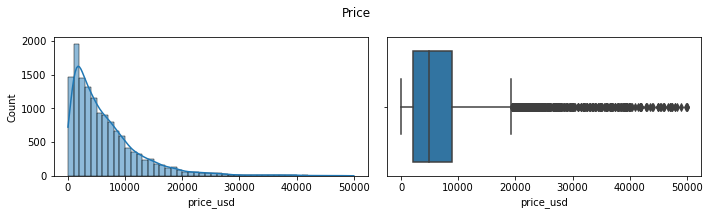

In [11]:
# Plot histograms to show distribution of the target variable
# Plot boxplot to determine “outliers” 
variable = 'price_usd'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.histplot(data=df, x=variable, kde=True, bins=50, ax=axs[0])
sns.boxplot(data=df, x=variable, ax=axs[1])

fig.suptitle('Price')
plt.tight_layout()

# Identify car price within 3 standard deviations (99.7% of observations)
quantile_left = df['price_usd'].quantile(0.0035)
quantile_right = df['price_usd'].quantile(0.9935)

low_price = len(df[df['price_usd']<quantile_left])
high_price = len(df[df['price_usd']>quantile_right])

print('00.35% percentile: ${:.2f}  - {} cars'.format(quantile_left, low_price))
print('99.35% percentile: ${:.2f} - {} cars'.format(quantile_right, high_price))

In [12]:
df['price_usd'].describe()

count    14026.000000
mean      6612.611518
std       6355.841508
min          1.000000
25%       2100.000000
50%       4800.000000
75%       8990.000000
max      50000.000000
Name: price_usd, dtype: float64

In [13]:
df.describe()

,odometer_value,year_produced,engine_capacity,duration_listed,price_usd
count,14026.00000,14026.000000,14026.000000,14026.000000,14026.000000
mean,247416.61935,2002.936333,2.057607,81.808855,6612.611518
std,134256.04593,8.096178,0.671651,120.978070,6355.841508
min,0.00000,1950.000000,0.200000,0.000000,1.000000
25%,156000.00000,1998.000000,1.600000,23.000000,2100.000000
50%,248000.00000,2003.000000,2.000000,59.000000,4800.000000
75%,322391.00000,2009.000000,2.300000,90.000000,8990.000000
max,1000000.00000,2019.000000,6.800000,2189.000000,50000.000000


QTR=df['price_usd'].quantile(0.75)-df['price_usd'].quantile(0.25)
low=df['price_usd'].quantile(0.25)-QTR*1.5
high=df['price_usd'].quantile(0.75)+QTR*1.5
print(low)
print(high)

In [14]:
# Round car price to hundreds
df['price_round']=df['price_usd'].apply(lambda x: round(x, -2))

# Create categories of car price
# Split prices into groups with step $500
price_range=range(0,50500, 500)           # range
price_labels=range(500,50500, 500)        # labels
print("Price segments: {}".format(len(price_range)))
df['price_range']=pd.cut(df['price_usd'],price_range,labels=price_labels)

# Create a feature how old is a car
df['year'] = 2020 - df['year_produced']

Price segments: 101


#### Predictor variables

#### Numeric variables

In [15]:
# Update a list of numeric columns
numeric_cols = df.drop('price_usd',axis=1).select_dtypes(numerics).columns.tolist()
df[numeric_cols].describe()

,odometer_value,year_produced,engine_capacity,duration_listed,price_round,year
count,14026.00000,14026.000000,14026.000000,14026.000000,14026.000000,14026.000000
mean,247416.61935,2002.936333,2.057607,81.808855,6613.738771,17.063667
std,134256.04593,8.096178,0.671651,120.978070,6356.212072,8.096178
min,0.00000,1950.000000,0.200000,0.000000,0.000000,1.000000
25%,156000.00000,1998.000000,1.600000,23.000000,2100.000000,11.000000
50%,248000.00000,2003.000000,2.000000,59.000000,4800.000000,17.000000
75%,322391.00000,2009.000000,2.300000,90.000000,9000.000000,22.000000
max,1000000.00000,2019.000000,6.800000,2189.000000,50000.000000,70.000000


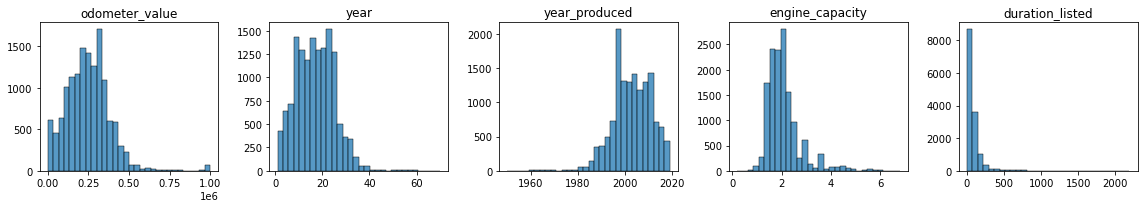

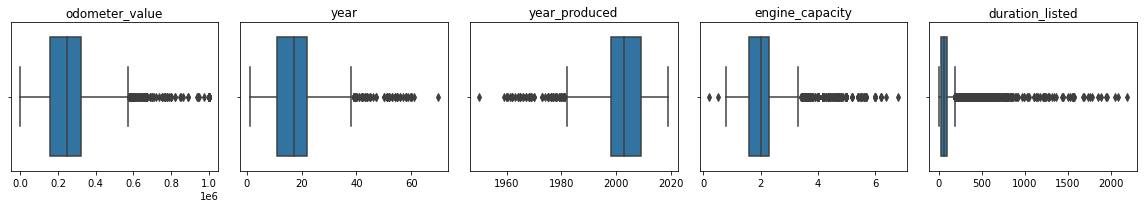

In [16]:
features=['odometer_value','year','year_produced','engine_capacity', 'duration_listed']
fig, axs = plt.subplots(1,5,figsize=(16,3))
for index,feature in enumerate(features):
    sns.histplot(data=df, x=feature, bins=30, ax=axs[index])
    axs[index].set_title(feature)
    axs[index].set_xlabel('')
    axs[index].set_ylabel('')
plt.tight_layout()

fig, axs = plt.subplots(1,5,figsize=(16,3), sharey=True)
for index,feature in enumerate(features):
    sns.boxplot(data=df, x=feature, ax=axs[index])
    axs[index].set_title(feature)
    axs[index].set_xlabel('')
plt.tight_layout()

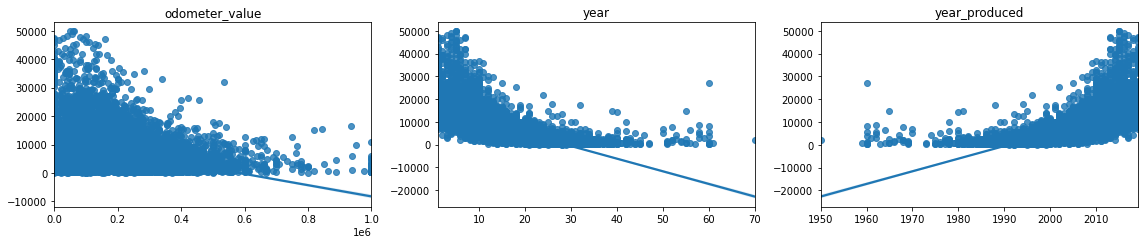

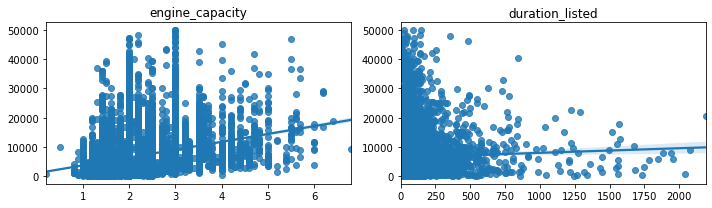

In [17]:
features = ['odometer_value','year', 'year_produced']
# Check relationship between numerical variables and car price
fig, axes = plt.subplots(1,3,figsize=(16,3.5))
for index,feature in enumerate(features):
    sns.regplot(x=feature,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(feature)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')
plt.tight_layout()

features = ['engine_capacity', 'duration_listed']
# Check relationship between numerical variables and car price
fig, axes = plt.subplots(1,2,figsize=(10,3))
for index,feature in enumerate(features):
    sns.regplot(x=feature,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(feature)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')
plt.tight_layout()

#### Categorical variables

In [18]:
# Update the list of categorical columns
categorical_cols = df.select_dtypes([np.object, np.bool]).columns.tolist()
print(len(categorical_cols))
print(categorical_cols)

21
['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel', 'engine_has_gas', 'engine_type', 'body_type', 'has_warranty', 'state', 'drivetrain', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


In [19]:
# Create sets of features
categorical_general = ['manufacturer_name', 'model_name', 'color', 'body_type'] 
categorical_main = ['transmission','has_warranty', 'state', 'drivetrain']
categorical_engine = ['engine_fuel', 'engine_has_gas', 'engine_type']
categorical_features = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
                        'feature_6', 'feature_7', 'feature_8', 'feature_9']

In [20]:
categ_list = list(set(categorical_cols)-set(categorical_features))
df[categ_list].describe()

,state,body_type,manufacturer_name,drivetrain,color,engine_type,engine_fuel,transmission,model_name,engine_has_gas,has_warranty
count,14026,14026,14026,14026,14026,14026,14026,14026,14026,14026,14026
unique,3,12,55,3,12,2,5,2,926,2,2
top,owned,sedan,Volkswagen,front,black,gasoline,gasoline,mechanical,Passat,False,False
freq,13721,4746,1540,10090,2765,9396,8801,9289,515,13521,13864


Unique manufacturers:  55
Frequency distributions for 'manufacturer_name' variable.
               count  percentage
Volkswagen      1540       10.98
Opel             987        7.04
Ford             954        6.80
BMW              895        6.38
Audi             888        6.33
Renault          876        6.25
Mercedes-Benz    834        5.95
Peugeot          680        4.85
Citroen          580        4.14
Mazda            510        3.64
Toyota           470        3.35
Nissan           468        3.34
Skoda            419        2.99
Hyundai          405        2.89
Kia              337        2.40
Mitsubishi       327        2.33
Fiat             313        2.23
Honda            309        2.20
Volvo            286        2.04
ВАЗ              169        1.20
Chrysler         162        1.15
Chevrolet        133        0.95
Dodge            125        0.89
Subaru           101        0.72
Seat              97        0.69
Rover             94        0.67
Suzuki            86     

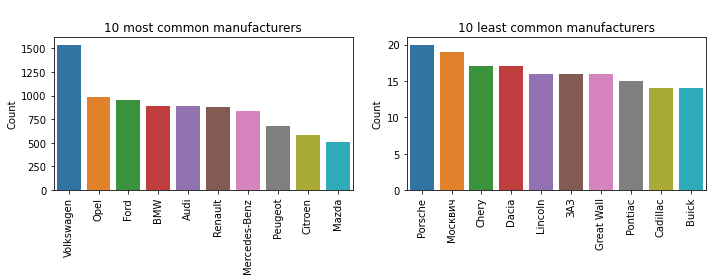

In [21]:
# Find out unique manufactures
manufacturers = df['manufacturer_name'].unique()
print('Unique manufacturers:  {}'.format(len(manufacturers)))
#print(manufacturers)

count_percent('manufacturer_name')

# Find out the most common and the least common car manufactures
df_manufacturers = pd.DataFrame(df['manufacturer_name'].value_counts()).reset_index()
df_manufacturers.columns=['Manufacturer', 'Count']

fig, axs = plt.subplots(1,2,figsize=(10,4))
x_df = df_manufacturers[:10]
sns.barplot(x='Manufacturer', y='Count', data=x_df, ax=axs[0])

x_df= df_manufacturers[len(df_manufacturers)-10:]
sns.barplot(x='Manufacturer', y='Count', data=x_df, ax=axs[1])

axs[0].xaxis.set_tick_params(rotation=90)
axs[1].xaxis.set_tick_params(rotation=90)

axs[0].set_title('\n10 most common manufacturers')
axs[1].set_title('\n10 least common manufacturers')

axs[0].set_xlabel('')
axs[1].set_xlabel('')

plt.tight_layout()

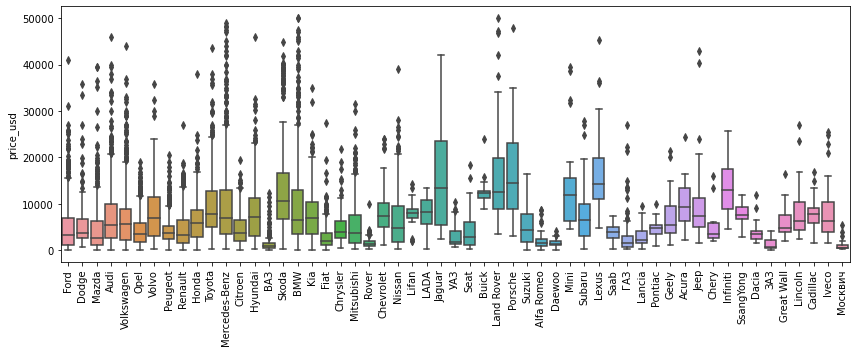

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
#sns.stripplot(x='manufacturer_name',y='price_usd',data=df, size=4, ax=ax)
sns.boxplot(x='manufacturer_name',y='price_usd',data=df, ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('')
plt.tight_layout()

Unique models:  926
Frequency distributions for 'name' variable.
(top 10 values)
                   count  percentage
Volkswagen Passat    515        3.67
Volkswagen Golf      278        1.98
Opel Astra           271        1.93
Audi A6              241        1.72
Ford Mondeo          224        1.60
Opel Vectra          220        1.57
Renault Laguna       198        1.41
Audi A4              187        1.33
Peugeot 406          165        1.18
Skoda Octavia        146        1.04


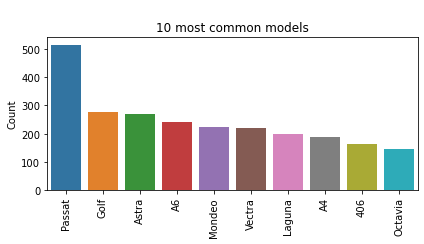

In [23]:
# Find out unique model names
models = df['model_name'].unique()
print('Unique models:  {}'.format(len(models)))
#print(models)

# Find out the most common and the least common car manufactures
df_models = pd.DataFrame(df['model_name'].value_counts()).reset_index()
df_models.columns=['Model', 'Count']

# Create bar plots of categorical variables
fig, axs = plt.subplots(1,1,figsize=(6,3.5))
x_df = df_models[:10]
sns.barplot(x='Model', y='Count', data=x_df, ax=axs)
axs.xaxis.set_tick_params(rotation=90)
axs.set_title('\n10 most common models')
axs.set_xlabel('')

plt.tight_layout()

# Combine manufacturer and model names 
df['name'] = df['manufacturer_name'].apply(lambda x: x.strip()) + ' ' + df['model_name'].apply(lambda x: x.strip())
# Find out number and percentage of models
count_percent('name', 140)

Frequency distributions for 'color' variable.
        count  percentage
black    2765       19.71
silver   2525       18.00
blue     2077       14.81
white    1577       11.24
grey     1373        9.79
red      1062        7.57
green    1024        7.30
other     961        6.85
brown     325        2.32
violet    169        1.20
yellow    114        0.81
orange     54        0.38


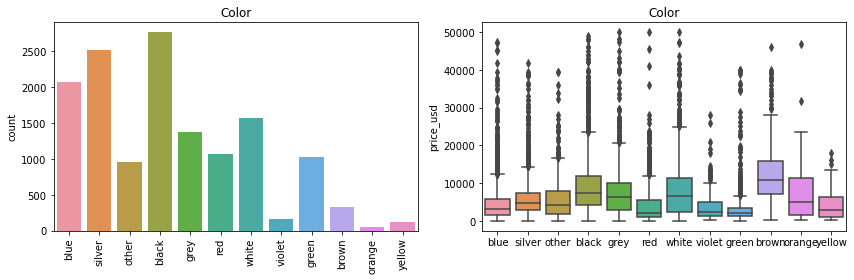

In [24]:
# Print frequency distributions
count_percent('color')
# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.countplot(x='color',data=df, ax=axs[0])
sns.boxplot(x='color',y='price_usd',data=df, ax=axs[1])
axs[0].xaxis.set_tick_params(rotation=90)
axs[0].set_title('Color')
axs[0].set_xlabel('')
axs[1].set_title('Color')
axs[1].set_xlabel('')
plt.tight_layout()

Frequency distributions for 'body_type' variable.
           count  percentage
sedan       4746       33.84
hatchback   2795       19.93
universal   1963       14.00
suv         1903       13.57
minivan     1287        9.18
minibus      517        3.69
van          275        1.96
coupe        241        1.72
liftback     215        1.53
pickup        50        0.36
cabriolet     26        0.19
limousine      8        0.06


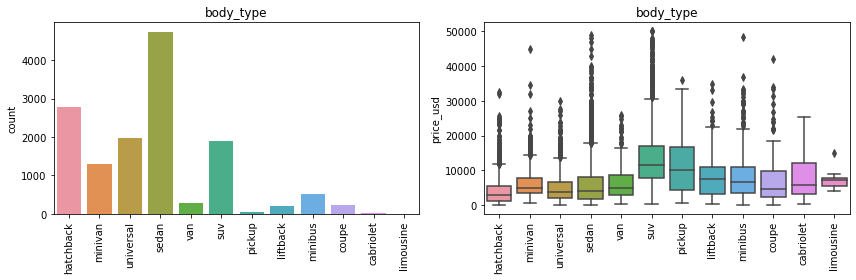

In [25]:
# Print frequency distributions
count_percent('body_type')
# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.countplot(x='body_type',data=df,ax=axs[0])
sns.boxplot(x='body_type',y='price_usd',data=df, ax=axs[1])
axs[0].xaxis.set_tick_params(rotation=90)
axs[0].set_title('body_type')
axs[0].set_xlabel('')
axs[1].xaxis.set_tick_params(rotation=90)
axs[1].set_title('body_type')
axs[1].set_xlabel('')
plt.tight_layout()

Frequency distributions for 'transmission' variable.
            count  percentage
mechanical   9289       66.23
automatic    4737       33.77
Frequency distributions for 'drivetrain' variable.
       count  percentage
front  10090       71.94
all     1980       14.12
rear    1956       13.95


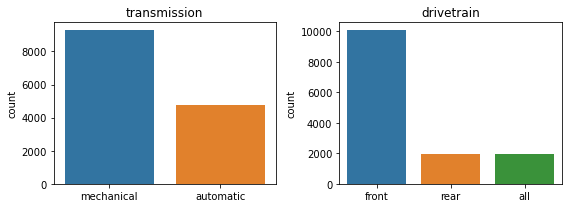

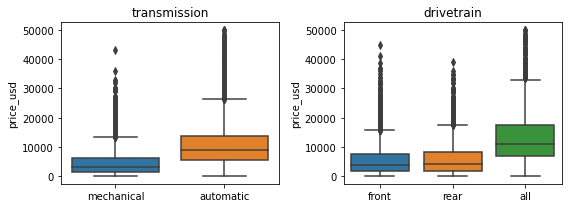

In [26]:
# Print frequency distributions
count_percent('transmission')
count_percent('drivetrain')
# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(8,3))
sns.countplot(x='transmission', data=df, ax=axs[0])
sns.countplot(x='drivetrain', data=df, ax=axs[1])

axs[0].set_title('transmission')
axs[0].set_xlabel('')
axs[1].set_title('drivetrain')
axs[1].set_xlabel('')
plt.tight_layout()

# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(8,3))
sns.boxplot(x='transmission',y='price_usd',data=df, ax=axs[0])
sns.boxplot(x='drivetrain',y='price_usd',data=df, ax=axs[1])

axs[0].set_title('transmission')
axs[0].set_xlabel('')
axs[1].set_title('drivetrain')
axs[1].set_xlabel('')
plt.tight_layout()

Frequency distributions for 'has_warranty' variable.
       count  percentage
False  13864       98.85
True     162        1.15
Frequency distributions for 'state' variable.
           count  percentage
owned      13721       97.83
new          168        1.20
emergency    137        0.98


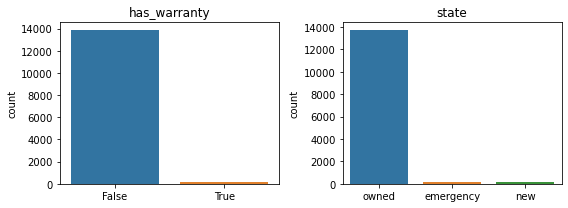

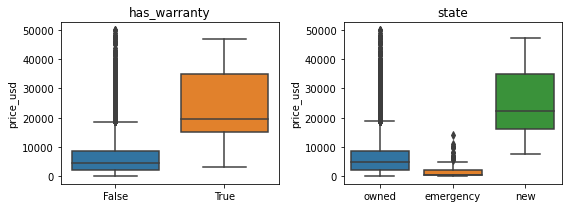

In [27]:
# Print frequency distributions
count_percent('has_warranty')
count_percent('state')

# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(8,3))
sns.countplot(x='has_warranty', data=df, ax=axs[0])
sns.countplot(x='state', data=df, ax=axs[1])

axs[0].set_title('has_warranty')
axs[0].set_xlabel('')
axs[1].set_title('state')
axs[1].set_xlabel('')
plt.tight_layout()

# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(8,3))
sns.boxplot(x='has_warranty',y='price_usd',data=df, ax=axs[0])
sns.boxplot(x='state',y='price_usd',data=df, ax=axs[1])

axs[0].set_title('has_warranty')
axs[0].set_xlabel('')
axs[1].set_title('state')
axs[1].set_xlabel('')
plt.tight_layout()

In [28]:
# Count unique values
categorical_engine = ['engine_fuel', 'engine_type']
for column in categorical_engine:
    print(pd.DataFrame(df[column].value_counts()))

               engine_fuel
gasoline              8801
diesel                4629
gas                    505
hybrid-petrol           90
hybrid-diesel            1
          engine_type
gasoline         9396
diesel           4630


In [29]:
################## Reduce a number of categories ############################
# Add 'hybrid-diesel' to 'diesel' category
df['engine_fuel']=df['engine_fuel'].replace({'hybrid-diesel':'diesel'})

Frequency distributions for 'engine_fuel' variable.
               count  percentage
gasoline        8801       62.75
diesel          4630       33.01
gas              505        3.60
hybrid-petrol     90        0.64
Frequency distributions for 'engine_type' variable.
          count  percentage
gasoline   9396       66.99
diesel     4630       33.01

505 car has a propane tank (use gas)


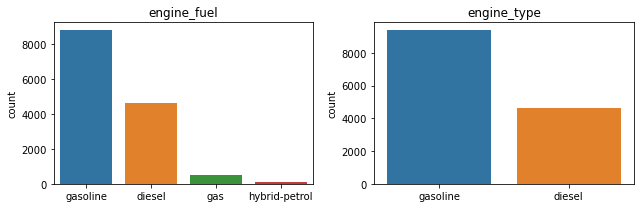

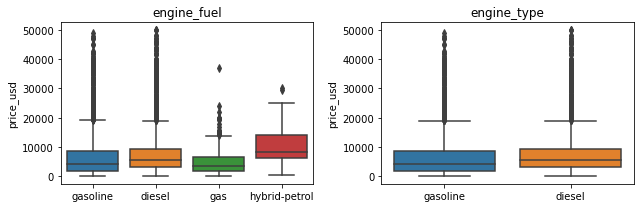

In [30]:
# Print frequency distributions
count_percent('engine_fuel')
count_percent('engine_type')

fig, axes = plt.subplots(ncols=len(categorical_engine),nrows=1,figsize=(9,3))
for index,column in enumerate(categorical_engine):
    sns.countplot(x=column, data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
plt.tight_layout()

# Check that number of observations with condition:
# 'engine_has_gas'==True and 'engine_fuel'=='gas' is 505.
mask_gas = (df['engine_has_gas'] ==True) & (df['engine_fuel']=='gas')
gas=len(df[mask_gas])
print('\n{} car has a propane tank (use gas)'.format(gas))

# Create bar plots of categorical variables
fig, axs = plt.subplots(1,2,figsize=(9,3))
sns.boxplot(x='engine_fuel',y='price_usd',data=df, ax=axs[0])
sns.boxplot(x='engine_type',y='price_usd',data=df, ax=axs[1])

axs[0].set_title('engine_fuel')
axs[0].set_xlabel('')
axs[1].set_title('engine_type')
axs[1].set_xlabel('')
plt.tight_layout()

Frequency distributions for 'feature_0' variable.
       count  percentage
False  10797       76.98
True    3229       23.02
Frequency distributions for 'feature_1' variable.
       count  percentage
True    8503       60.62
False   5523       39.38
Frequency distributions for 'feature_2' variable.
       count  percentage
False  10848       77.34
True    3178       22.66
Frequency distributions for 'feature_3' variable.
       count  percentage
False  10138       72.28
True    3888       27.72
Frequency distributions for 'feature_4' variable.
       count  percentage
False  10647       75.91
True    3379       24.09
Frequency distributions for 'feature_5' variable.
       count  percentage
False   9095       64.84
True    4931       35.16
Frequency distributions for 'feature_6' variable.
       count  percentage
False  11660       83.13
True    2366       16.87
Frequency distributions for 'feature_7' variable.
       count  percentage
False  10390       74.08
True    3636       25.92


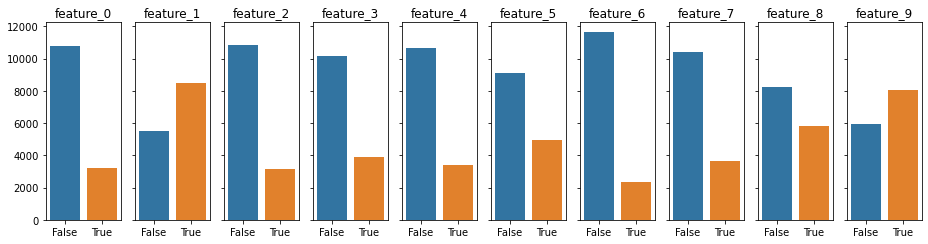

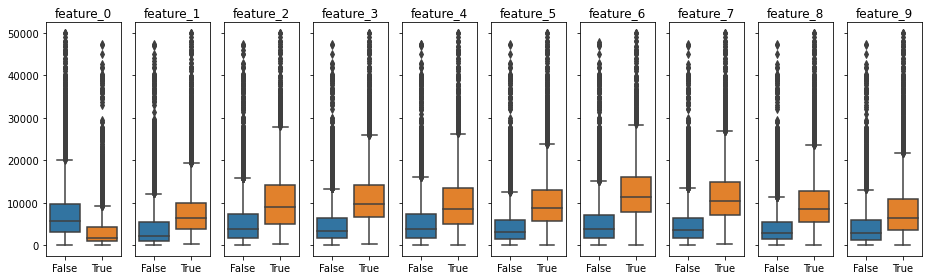

In [31]:
# Print frequency distributions
for feature in categorical_features:
    count_percent(feature)

fig, axes = plt.subplots(ncols=len(categorical_features),nrows=1,figsize=(13,3.5), sharey=True)
for index,column in enumerate(categorical_features):
    sns.countplot(x=column, data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')
plt.tight_layout()

# Create box plots of categorical variables
fig, axes = plt.subplots(ncols=len(categorical_features), nrows=1, figsize=(13,4), sharey=True )
for index,column in enumerate(categorical_features):
    sns.boxplot(x=column,y='price_usd',data=df, ax=axes[index])
    axes[index].set_title(column)
    axes[index].set_xlabel('')
    axes[index].set_ylabel('')
plt.tight_layout()

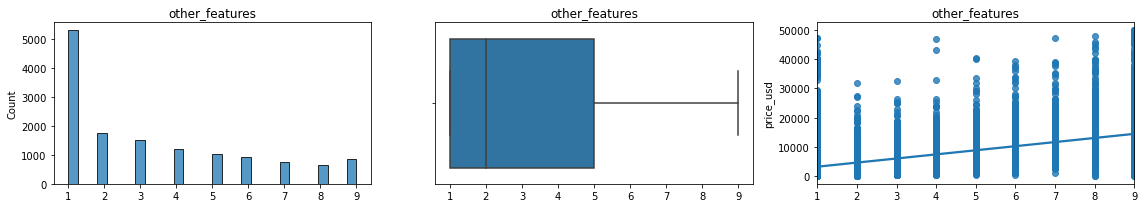

In [32]:
# Count a total number of unnamed features for a car
df['other_features']=df[categorical_features].sum(axis=1).astype(int)

feature='other_features'
fig, axs = plt.subplots(1,3,figsize=(16,3))
sns.histplot(data=df, x=feature, bins=30, ax=axs[0])
sns.boxplot(data=df, x=feature, ax=axs[1])
sns.regplot(data=df, x=feature,y='price_usd', ax=axs[2])

axs[0].set_title(feature)
axs[0].set_xlabel('')
#axs[0].set_ylabel('')
axs[1].set_title(feature)
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[2].set_title(feature)
axs[2].set_xlabel('')
#axs[2].set_ylabel('')
plt.tight_layout()

Text(0.5, 78.0, '')

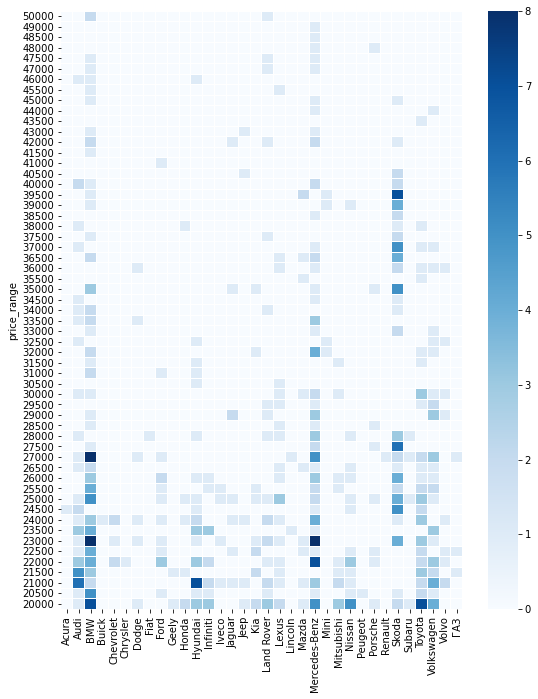

In [33]:
manufacturer_df=pd.crosstab(df['price_range'], df['manufacturer_name']).sort_values(by='price_range', ascending=False)
manufacturer_df=pd.DataFrame(manufacturer_df)

fig, ax = plt.subplots(figsize=(9,11))
df_1=manufacturer_df.loc[:20000]

df_sum=df_1.sum()
df_1=df_1[list(df_sum[df_sum>0].index)]

sns.heatmap(df_1, cmap='Blues', linewidths=0.01)
ax.set_xlabel('')

Text(0.5, -3.0, '')

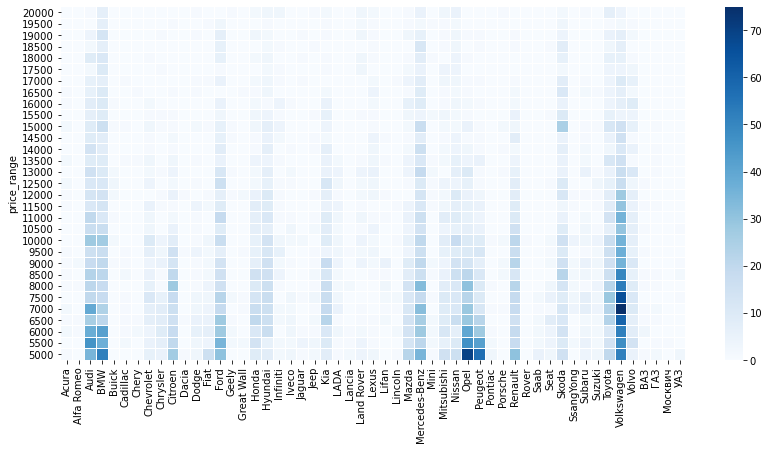

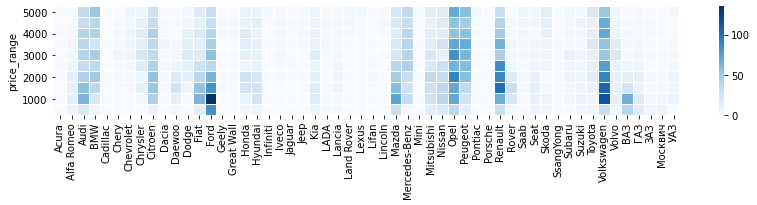

In [34]:
fig, ax = plt.subplots(figsize=(14,6.5))
df_1=manufacturer_df.loc[20000:5000]

df_sum=df_1.sum()
df_1=df_1[list(df_sum[df_sum>0].index)]

sns.heatmap(df_1, cmap='Blues', linewidths=0.01)
ax.set_xlabel('')

fig, ax = plt.subplots(figsize=(14,2))
df_1=manufacturer_df.loc[5000:]

df_sum=df_1.sum()
df_1=df_1[list(df_sum[df_sum>0].index)]

sns.heatmap(df_1, cmap='Blues', linewidths=0.01)
ax.set_xlabel('')

### Feature engineering

In [35]:
# Create a feature that represents mileage per year
df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']))
# Create a feature how old is a car
df['year'] = 2020 - df['year_produced']

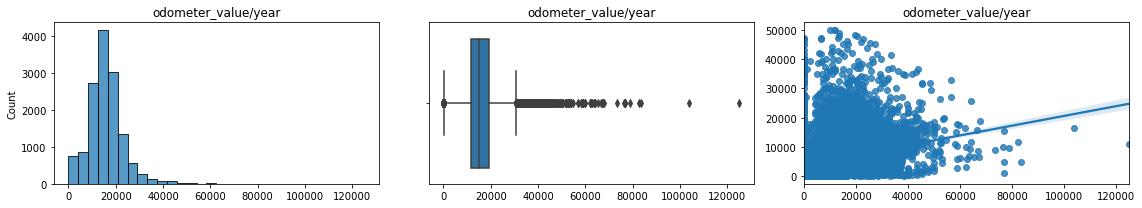

In [36]:
feature='odometer_value/year'
fig, axs = plt.subplots(1,3,figsize=(16,3))
sns.histplot(data=df, x=feature, bins=30, ax=axs[0])
sns.boxplot(data=df, x=feature, ax=axs[1])
sns.regplot(data=df, x=feature,y='price_usd', ax=axs[2])

axs[0].set_title(feature)
axs[0].set_xlabel('')
#axs[0].set_ylabel('')
axs[1].set_title(feature)
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[2].set_title(feature)
axs[2].set_xlabel('')
axs[2].set_ylabel('')
plt.tight_layout()


### Dealing with outliers

In [37]:
# Numerical features
mask1=(df['odometer_value'] > 250000) & (df['price_usd']>30000)
mask2=(df['year_produced'] < 1955) 
mask3=(df['year_produced'] < 1970) & (df['price_usd']>10000)
mask4=(df['engine_capacity'] < 0.8)
mask5=(df['odometer_value/year']>95000)
mask6=(df['duration_listed']>2100)

# Combine all filters
outliers = df[mask1|mask2|mask3|mask4|mask5|mask6]
#outliers

# Save the rows with extreme outliers to csv file
fl = "4. Analysis/used_car_prices_EDA_extreme_outliers.csv"
outliers.to_csv(fl, index=False)
       
print("Dataset: {}".format(df.shape))
df.drop(outliers.index, inplace=True )
df.reset_index(drop=True)
print('Drop {} outliers'.format(len(outliers)))
print("Dataset: {}".format(df.shape))       

Dataset: (14026, 32)
Drop 11 outliers
Dataset: (14015, 32)


Text(0.5, 1.0, 'Correlation Matrix')

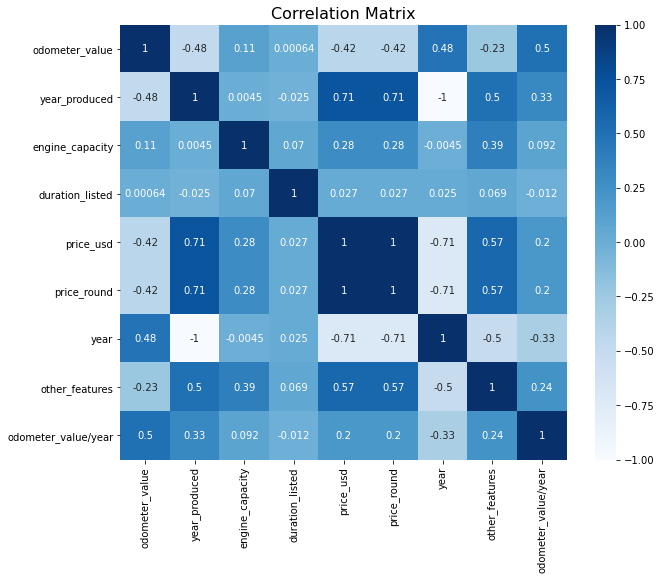

In [38]:
# Update a list of numeric columns
numeric_cols = df.select_dtypes(numerics).columns.tolist()

# Check correlation between independent variables
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr,annot=True,cmap='Blues')
plt.title('Correlation Matrix', fontsize=fontsize) 

In [39]:
# Create a copy of data
df_tr = df.copy()

# Select numeric features
features=['odometer_value','year','engine_capacity', 'duration_listed', 'odometer_value/year', 'other_features']

### Regression Assumptions

1. Normality  
2. Linearity  
3. Homoscedasticity  
4. Independence  
5. Multicollinearity  
6. Outliers  

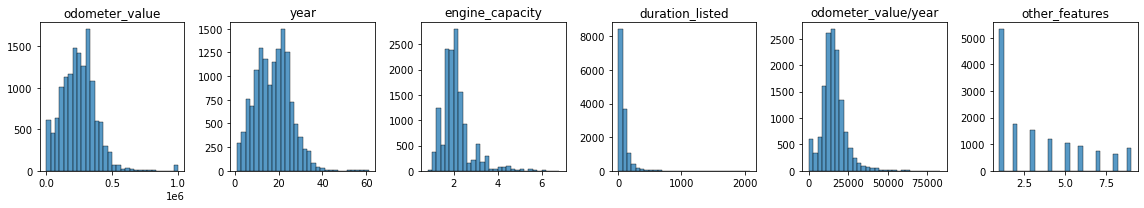

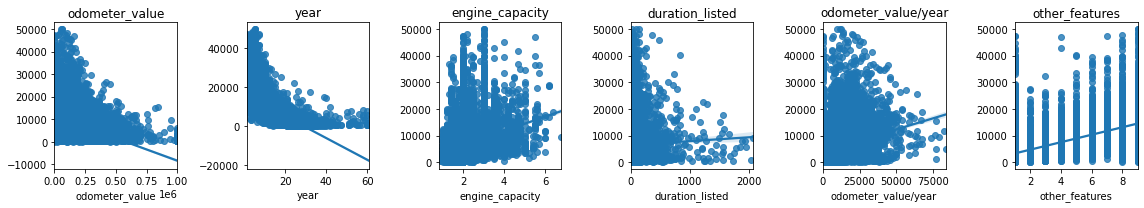

In [40]:
# Check Normality, Linearity, and Outliers

# Plot histograms before transformation
fig, axs = plt.subplots(1,6,figsize=(16,3))
for index,feature in enumerate(features):
    sns.histplot(data=df_tr, x=feature, bins=30, ax=axs[index])
    axs[index].set_title(feature)
    axs[index].set_xlabel('')
    axs[index].set_ylabel('')
plt.tight_layout()

# Plot regplots before transformation
fig, axes = plt.subplots(1,6,figsize=(16,3))
for index,feature in enumerate(features):
    sns.regplot(data=df_tr, x=feature, y='price_usd', ax=axes[index])
    axes[index].set_title(feature)
    axes[index].set_ylabel('')
plt.tight_layout()

### Transformation the target and predictor variables

#### The target variable

<AxesSubplot:xlabel='price_round', ylabel='Count'>

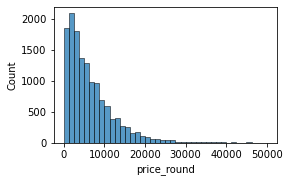

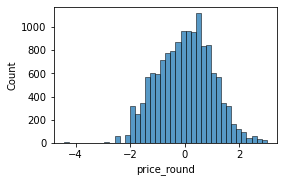

In [41]:
# Plot a histogram before transformation
fig, axs = plt.subplots(figsize=(4,2.5))
sns.histplot(data=df_tr, x='price_round', bins=40)

# Applies Power Transformer using Yeo-Johnson transformation to target variable
power = PowerTransformer(method='yeo-johnson')
df_tr['price_round'] = power.fit_transform(np.array(df_tr['price_round']).reshape(-1, 1))

# Plot a histogram after transformation
fig, axs = plt.subplots(figsize=(4,2.5))
sns.histplot(data=df_tr, x='price_round', bins=40)

#### Predictor variables

In [42]:
# Applies Power Transformer using Yeo-Johnson transformation to numeric variables
numeric_power = ['odometer_value', 'odometer_value/year', 'duration_listed']

power = PowerTransformer(method='yeo-johnson')
df_tr[numeric_power] = power.fit_transform(df_tr[numeric_power])

# Applies Quantile Transformer to numeric variables 
numeric_quantile = ['engine_capacity', 'year']

quantile = QuantileTransformer( output_distribution='normal')# n_quantiles=10,
df_tr[numeric_quantile] = quantile.fit_transform(df_tr[numeric_quantile])

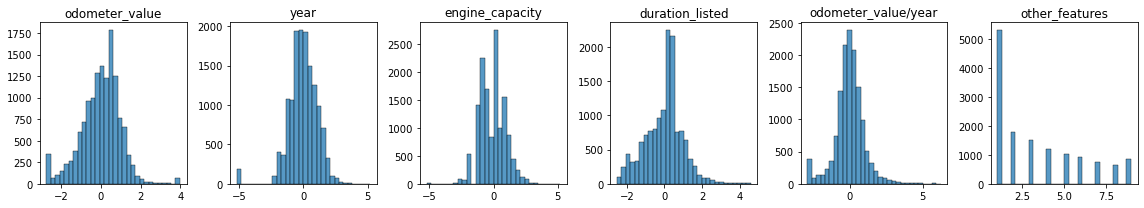

In [43]:
# Plot histograms after transformation
fig, axs = plt.subplots(1,6,figsize=(16,3))
for index,feature in enumerate(features):
    sns.histplot(data=df_tr, x=feature, bins=30, ax=axs[index])
    axs[index].set_title(feature)
    axs[index].set_xlabel('')
    axs[index].set_ylabel('')
plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix')

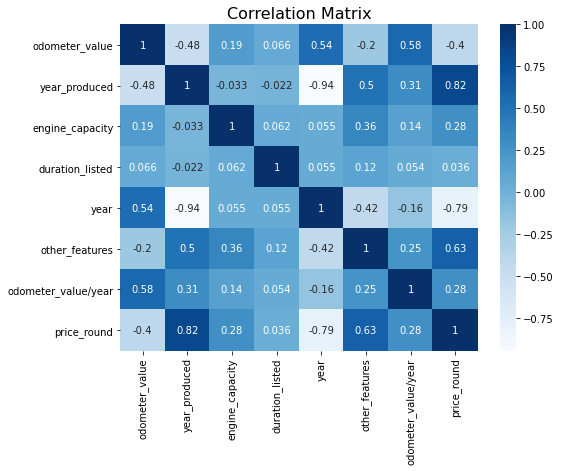

In [44]:
# Check Multicollinearity

# Delete 'price_usd', 'price_round' from the list of numeric columns
numeric_cols = [e for e in numeric_cols if e not in ('price_usd', 'price_round')]

# Check no correlation between independent variables
corr = df_tr[numeric_cols+['price_round']].corr()

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(corr,annot=True,cmap='Blues')
plt.title('Correlation Matrix', fontsize=fontsize) 

Data meets following assumptions.
2. Linearity.  
Association between predictor and target variables could be considered as linear.
4. Independence.
Data consists of independent observations.
5. Multicollinearity.
Two variables 'year' and 'year_produced' are highly correlated predictor variables. So only one -  'year' will be used for prediction.
6. Outliers. 
There is no extreeme outliers. Related 11 observations were deleted during data cleaning process and save in file "4. Analysis/used_car_prices_extreme_outliers.csv".

Other assumptions will be checked in modelining part.
1. Normality.  
Residuals are normally distributed.
3. Homoscedasticity.  
The variability in the response variable is the same at all levels of the explanatory variable.